In [1]:
import numpy as np
import matplotlib.pyplot as plt
import asdf
from matplotlib import rc
from scipy.optimize import curve_fit
import symlib
import sys
sys.path.append('/sdf/home/j/jaymarie/software/gravitree/python')
import gravitree
from scipy.integrate import quad
import astropy.constants as cons
import astropy.units as u
from tqdm import tqdm
from glob import glob

from plot import setFonts
setFonts()

from gala.potential import PlummerPotential
from gala.dynamics import PhaseSpacePosition

from gala.units import galactic

sim_dir = "/fs/ddn/sdf/group/kipac/g/cosmo/ki21/phil1/simulations/ZoomIns/SymphonyMilkyWay/Halo023"

from mwgcs import Simulation, GCSystem, MassProfile, NFW

sim = Simulation(sim_dir)

Gravitree path added to sys.path.


# plummer

In [2]:
def analyticPotential(r, m, a):
    return -cons.G * m / (r**2 + a**2)**(1/2)


def plummerHessianCartesian(x, y, z, a, m):
    denom = (a**2 + x**2 + y**2 + z**2)**(5/2)
    h_xx = (cons.G * m * (a**2 - 2*x**2 + y**2 + z**2) / denom).to(u.Gyr**(-2)).value
    h_yy = (cons.G * m * (a**2 + x**2 - 2*y**2 + z**2) / denom).to(u.Gyr**(-2)).value
    h_zz = (cons.G * m * (a**2 + x**2 + y**2 - 2*z**2) / denom).to(u.Gyr**(-2)).value
    h_xy = h_yx = (cons.G * m * - 3 * x * y / denom).to(u.Gyr**(-2)).value
    h_xz = h_zx = (cons.G * m * - 3 * x * z / denom).to(u.Gyr**(-2)).value
    h_yz = h_zy = (cons.G * m * - 3 * y * z / denom).to(u.Gyr**(-2)).value
    
    hess = np.array([
        [h_xx, h_xy, h_xz],
        [h_yx, h_yy, h_yz],
        [h_zx, h_zy, h_zz]
    ])
    
    return hess

def analyticPotential_r(r, m, a):
    return cons.G * m * r / (r**2 + a**2)**(3/2)

def analyticPotential_rr(m, r, a):
    phi_rr = - (cons.G * m * ((2 * (r**2.)) - (a**2.))) / (r**2 + a**2)**(5/2)
    return phi_rr.to(u.Gyr**(-2))

def numericalPotential_rr(r, m, a):
    

def analyticLambdaBaryon(m, r, a):
    phi_rr = - (cons.G * m * ((2 * (r**2.)) - (a**2.))) / (r**2 + a**2)**(5/2)
    return np.abs(phi_rr * (2/3)).to(u.Gyr**(-2))

In [3]:
r_exp = 3 * u.kpc
r_half = np.log(2) * r_exp
a = (r_half / (1.3)).value
m0 = 4e10

In [34]:
pot = PlummerPotential(m0 * u.Msun, a * u.kpc, units=galactic) 

r = np.logspace(-1, 3, 1000)
lams = []
for r_i in r:
    H_ij = pot.hessian([r_i, 0, 0]).reshape(3,3)
    tensor = (-(1/3)*np.trace(H_ij) * np.identity(3) + H_ij)
    lam = (np.max(np.abs(np.linalg.eig(tensor)[0]))).to(1/u.Gyr**2).value
    # lam = np.abs(2*H_ij[0,0]/3).to(1/u.Gyr**2).value
    lams.append(lam)

In [35]:
lams_b_analytic = analyticLambdaBaryon(m0 * u.Msun, r * u.kpc, a * u.kpc)

lams_cart = []
for r_i in r:
    H_ij = plummerHessianCartesian(r_i * u.kpc, 0 * u.kpc, 0 * u.kpc, a * u.kpc, m0 * u.Msun)
    tensor = (-(1/3)*np.trace(H_ij) * np.identity(3) + H_ij)
    lam = (np.max(np.abs(np.linalg.eig(tensor)[0])))
    lams_cart.append(lam)

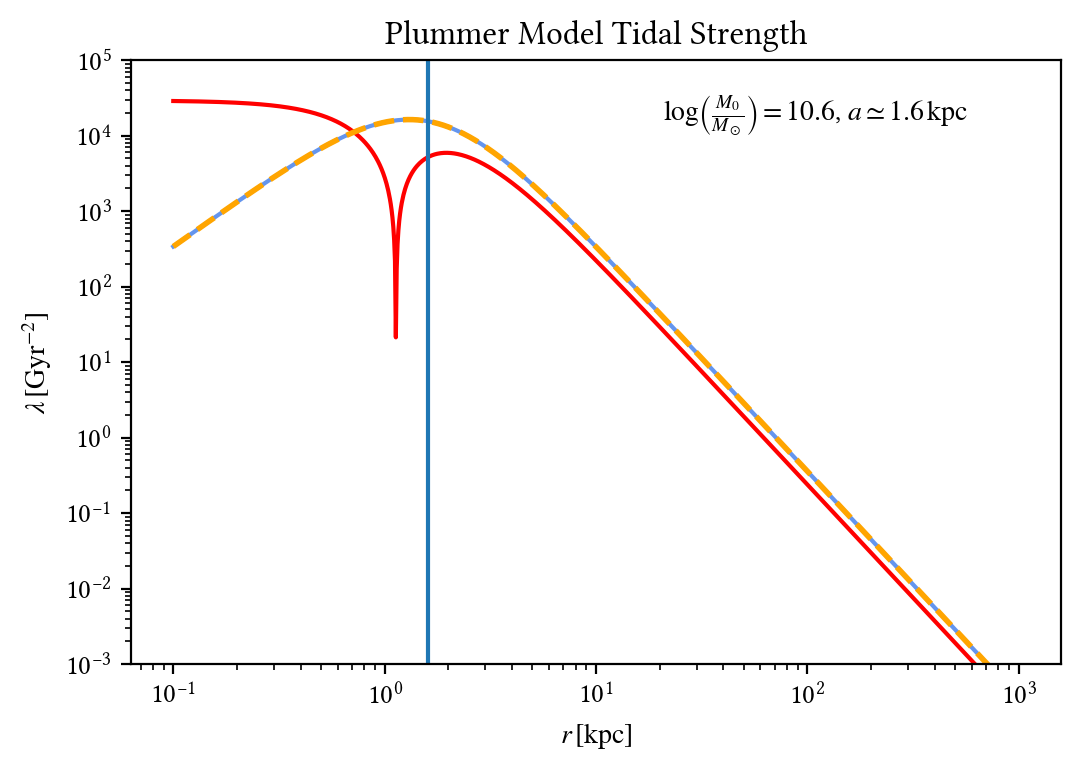

In [36]:
fig, ax = plt.subplots(dpi=200)
ax.loglog(r, lams, c='cornflowerblue')
ax.loglog(r, lams_b_analytic, c='red')
ax.loglog(r, lams_cart, c='orange', ls='--', lw=2)
ax.set_title(r'Plummer Model Tidal Strength')
ax.text(.9, .9, r'$\log\left(\frac{M_0}{M_\odot}\right) = 10.6$, $a \simeq 1.6 \mathrm{\, kpc}$', transform=ax.transAxes, ha='right')
ax.set_ylabel(r'$\lambda\, \mathrm{[Gyr^{-2}]}$')
ax.set_xlabel(r'$r \, \mathrm{[kpc]}$')
ax.set_ylim(1e-3, 1e5)
ax.axvline(a)
plt.show()

In [37]:
_gh = pot.hessian([1e-1, 0, 0]).to(1/u.Gyr**2).value.reshape(3,3)
_mh = plummerHessianCartesian(1e-1 * u.kpc, 0 * u.kpc, 0 * u.kpc, a * u.kpc, m0 * u.Msun)

In [47]:
pot.hessian([1e-2, 0, 0]).to(1/u.Gyr**2).value.reshape(3,3)

array([[43958.35693935,     0.        ,     0.        ],
       [    0.        , 43963.51147951,     0.        ],
       [    0.        ,     0.        , 43963.51147951]])

In [31]:
_gh.reshape(3,3).shape, _mh.shape

((3, 3), (3, 3))

In [38]:
gala_vc = pot.circular_velocity(np.array([r * u.kpc, np.zeros_like(r), np.zeros_like(r)]))
analytic_vc = np.sqrt(r * u.kpc * analyticPotential_r(r * u.kpc, m0 * u.Msun, a * u.kpc)).to(u.km/u.s)

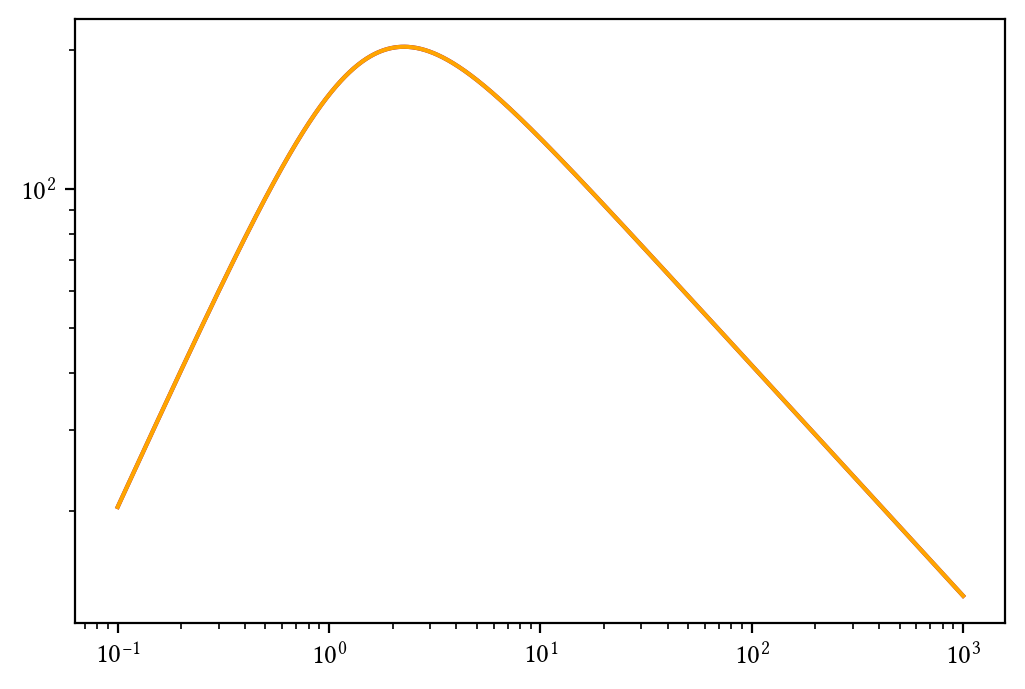

In [39]:
fig, ax = plt.subplots(dpi=200)
ax.loglog(r, gala_vc, c='purple', label='gala')
ax.loglog(r, analytic_vc, c='orange', label='homemade')
plt.show()

In [40]:
homemade_rr = analyticPotential_rr(m0 * u.Msun, r * u.kpc, a * u.kpc).to(u.Gyr**(-2))
gala_rr = pot.hessian(np.array([r * u.kpc, np.zeros_like(r), np.zeros_like(r)]))[0, 0].to(u.Gyr**(-2))

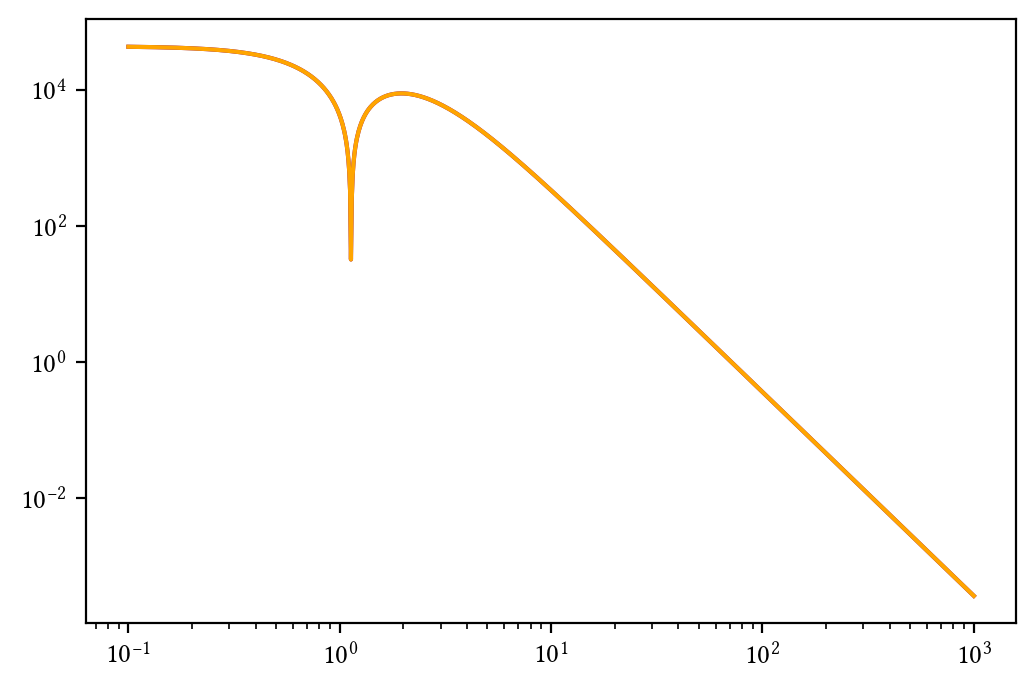

In [41]:
fig, ax = plt.subplots(dpi=200)
ax.loglog(r, np.abs(gala_rr), c='purple', label='gala')
ax.loglog(r, np.abs(homemade_rr), c='orange', label='homemade')
plt.show()

In [42]:
homemade_pot = analyticPotential(r * u.kpc, m0 * u.Msun, a * u.kpc).to(u.km**2 / u.s**2)
gala_pot = pot(np.array([r * u.kpc, np.zeros_like(r), np.zeros_like(r)])).to(u.km**2 / u.s**2)

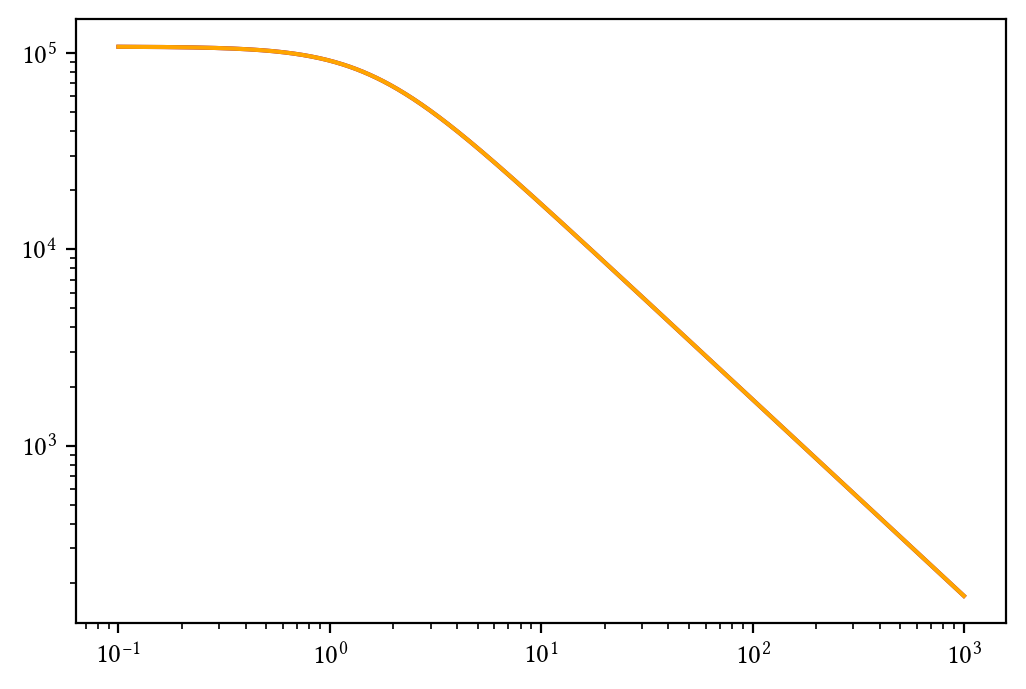

In [43]:
fig, ax = plt.subplots(dpi=200)
ax.loglog(r, np.abs(homemade_pot), c='purple', label='gala')
ax.loglog(r, np.abs(gala_pot), c='orange', label='homemade')
plt.show()

In [44]:
# can I calculate second derivatives using jax?

# composite

In [45]:
profile = MassProfile(sim, 235, 0)
m = 2e5
_ = profile.fit()
r_t_mw = np.array([tidalRadius(R_i, m, profile) for R_i in r], dtype=object) * u.kpc
lams_dm = (cons.G * m * u.Msun / (r_t_mw)**3).to(u.Gyr**(-2))

/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


NameError: name 'tidalRadius' is not defined

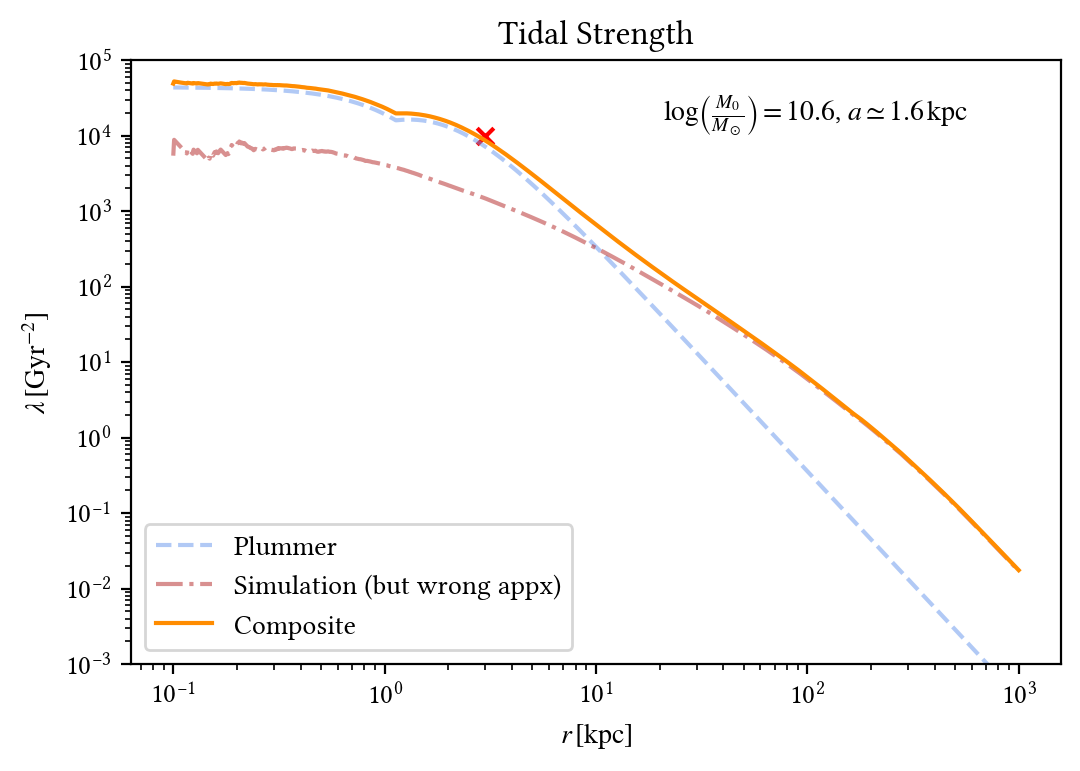

In [13]:
fig, ax = plt.subplots(dpi=200)
ax.loglog(r, lams, c='cornflowerblue', ls='--', alpha=.5, label='Plummer')
ax.loglog(r, lams_dm, c='firebrick', ls='-.', alpha=.5, label='Simulation (but wrong appx)')
ax.loglog(r, lams+lams_dm.value, c='darkorange', label='Composite')

ax.scatter(3., 1e4, marker='x', c='r')

ax.set_title(r'Tidal Strength')
ax.text(.9, .9, r'$\log\left(\frac{M_0}{M_\odot}\right) = 10.6$, $a \simeq 1.6 \mathrm{\, kpc}$', transform=ax.transAxes, ha='right')
ax.set_ylabel(r'$\lambda\, \mathrm{[Gyr^{-2}]}$')
ax.set_xlabel(r'$r \, \mathrm{[kpc]}$')
ax.set_ylim(1e-3, 1e5)
ax.legend(loc='lower left')
plt.show()

In [14]:
gc = GCSystem(sim, 2)

/sdf/home/j/jaymarie/mwgcs/mwgcs/form.py:15: RuntimeWarning: invalid value encountered in log10
  mgc = 1/(1 + np.exp(-(b0 + (b1 * np.log10(ms))))) * (g0 + (g1*np.log10(ms)))
/opt/conda/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [15]:
gc.evolve(0)

0it [00:02, ?it/s]


AttributeError: 'NoneType' object has no attribute 'analyticSlope'

In [ ]:
gc.profile.fit()

In [ ]:
gc.profile._ein.analyticSlope